In [30]:
import pandas as pd
# Import des bases de données en dataframes
df_conso_elec__Auvergne_Rhone_Alpes = pd.read_csv(r'C:\Users\guill\Documents\Formation_data_scientist\Projet\BaseDeDonnees\conso_elec\Auvergne-Rhone-Alpes.csv', delimiter=';')
df_meteo__01_2024_2025 = pd.read_csv(r'C:\Users\guill\Documents\Formation_data_scientist\Projet\BaseDeDonnees\meteo\H_01_latest-2024-2025.csv', delimiter=';')
df_meteo__01_2020_2023 = pd.read_csv(r'C:\Users\guill\Documents\Formation_data_scientist\Projet\BaseDeDonnees\meteo\H_01_previous-2020-2023.csv', delimiter=';')

In [31]:
# Conso elec Premières infos
df_conso_elec__Auvergne_Rhone_Alpes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2877216 entries, 0 to 2877215
Data columns (total 15 columns):
 #   Column                                        Dtype  
---  ------                                        -----  
 0   Horodate                                      object 
 1   Région                                        object 
 2   Code région                                   int64  
 3   Profil                                        object 
 4   Plage de puissance souscrite                  object 
 5   Nb points soutirage                           int64  
 6   Total énergie soutirée (Wh)                   float64
 7   Courbe Moyenne n°1 (Wh)                       float64
 8   Indice représentativité Courbe n°1 (%)        object 
 9   Courbe Moyenne n°2 (Wh)                       float64
 10  Indice représentativité Courbe n°2 (%)        object 
 11  Courbe Moyenne n°1 + n°2 (Wh)                 float64
 12  Indice représentativité Courbe n°1 + n°2 (%)  object 
 1

In [32]:
# Conso elec Valeurs manquantes 
df_conso_elec__Auvergne_Rhone_Alpes.isnull().sum()

Horodate                                             0
Région                                               0
Code région                                          0
Profil                                               0
Plage de puissance souscrite                         0
Nb points soutirage                                  0
Total énergie soutirée (Wh)                      70172
Courbe Moyenne n°1 (Wh)                         347708
Indice représentativité Courbe n°1 (%)               0
Courbe Moyenne n°2 (Wh)                         349340
Indice représentativité Courbe n°2 (%)               0
Courbe Moyenne n°1 + n°2 (Wh)                   195592
Indice représentativité Courbe n°1 + n°2 (%)         0
Jour max du mois (0/1)                               0
Semaine max du mois (0/1)                            0
dtype: int64

In [33]:
# Nous concentrons l'étude sur le total d'énergie soutirée
features_interest = ['Horodate', 'Profil', 'Plage de puissance souscrite', 'Nb points soutirage', 'Total énergie soutirée (Wh)']
df_conso_elec__Auvergne_Rhone_Alpes = df_conso_elec__Auvergne_Rhone_Alpes[features_interest]

In [34]:
# Suppression des valeurs manquantes
df_conso_elec__Auvergne_Rhone_Alpes = df_conso_elec__Auvergne_Rhone_Alpes.dropna()

In [35]:
# Nous concentrons l'étude sur les puissances souscrites et aggrégeons les profils sur ces derniers
df_conso_elec__Auvergne_Rhone_Alpes = df_conso_elec__Auvergne_Rhone_Alpes.groupby(['Horodate','Plage de puissance souscrite']).agg({
    'Nb points soutirage': 'sum',
    'Total énergie soutirée (Wh)': 'sum'
}).reset_index()

In [36]:
# La base météo étant avec un pas = 1h, nous sommons pour avoir un total d'énergie soutirée par heure

# Conversion d'Horodate en format datetime pandas
df_conso_elec__Auvergne_Rhone_Alpes['Horodate'] = pd.to_datetime(df_conso_elec__Auvergne_Rhone_Alpes['Horodate'], utc=True)

In [37]:
# Arrondi de l'horodate pour faire un groupby
df_conso_elec__Auvergne_Rhone_Alpes['Horodate arrondie'] = df_conso_elec__Auvergne_Rhone_Alpes['Horodate'].dt.floor('h')
# Somme de l'énergie soutirée pour l'avoir par heure
df_conso_elec__Auvergne_Rhone_Alpes = df_conso_elec__Auvergne_Rhone_Alpes.groupby(['Horodate arrondie', 'Plage de puissance souscrite', 'Nb points soutirage']).agg({
    'Total énergie soutirée (Wh)': 'sum'  # Somme de l'énergie soutirée
}).reset_index()

In [38]:
# On se focalise sur Température (T), Humidité (U) et Vent (FF)
features_interest_meteo = ['AAAAMMJJHH', 'NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'T', 'U', 'FF']
df_meteo__01_2020_2023 = df_meteo__01_2020_2023[features_interest_meteo]
df_meteo__01_2024_2025 = df_meteo__01_2024_2025[features_interest_meteo]

In [39]:
# Concaténation des dataframes
df_meteo__01_2020_2025 = pd.concat([df_meteo__01_2020_2023, df_meteo__01_2024_2025], ignore_index=True)

In [40]:
# On moyenne les valeurs sur l'ensemble des postes du département pour chaque heure
df_meteo__01_2020_2025_moyenne = df_meteo__01_2020_2025.groupby(['AAAAMMJJHH']).agg({
    'T': 'mean',
    'U': 'mean',
    'FF': 'mean'
}).reset_index()
# Il serait intéressant ici aussi d'étudier la dispersion de la température entre les postes météos d'un département

In [41]:
# Conversion en format pandas datetime
df_meteo__01_2020_2025_moyenne['Date'] = pd.to_datetime(df_meteo__01_2020_2025_moyenne['AAAAMMJJHH'], format='%Y%m%d%H')

In [42]:
# On ne garde que les données entre 2023 et 2024
start_date = '2023-01-01'
end_date = '2025-01-01'
df_meteo__01_2023_2024_moyenne = df_meteo__01_2020_2025_moyenne[(df_meteo__01_2020_2025_moyenne['Date'] >= start_date) & (df_meteo__01_2020_2025_moyenne['Date'] < end_date)]

In [43]:
# Conversion en datetime sans fuseau horaire pour merge
df_conso_elec__Auvergne_Rhone_Alpes['Horodate arrondie'] = df_conso_elec__Auvergne_Rhone_Alpes['Horodate arrondie'].dt.tz_localize(None)
####### !!!!!!!!!!!!! J'ai l'impression que je perds la 23e heure ici !

In [44]:
# Merge des deux dataframes
df_conso_elec_meteo = pd.merge(df_conso_elec__Auvergne_Rhone_Alpes, df_meteo__01_2023_2024_moyenne, left_on='Horodate arrondie', right_on='Date', how='inner')
df_conso_elec_meteo = df_conso_elec_meteo[['Date', 'Plage de puissance souscrite', 'Nb points soutirage', 'Total énergie soutirée (Wh)', 'T', 'U', 'FF']]

In [45]:
df_conso_elec_meteo['Annee'] = df_conso_elec_meteo['Date'].dt.year
df_conso_elec_meteo['Mois'] = df_conso_elec_meteo['Date'].dt.month
df_conso_elec_meteo['Jour'] = df_conso_elec_meteo['Date'].dt.day
df_conso_elec_meteo['Heure'] = df_conso_elec_meteo['Date'].dt.hour

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
# Focus sur une puissance souscrite pour l'exerice
df_conso_elec_meteo_focus = df_conso_elec_meteo[df_conso_elec_meteo['Plage de puissance souscrite']=='P1: ]0-6] kVA']
df_conso_elec_meteo_focus = df_conso_elec_meteo_focus.drop(['Plage de puissance souscrite', 'Nb points soutirage'], axis=1)

In [48]:
df_corr = df_conso_elec_meteo_focus[['Mois', 'Jour', 'Heure', 'Total énergie soutirée (Wh)', 'T', 'U', 'FF']]

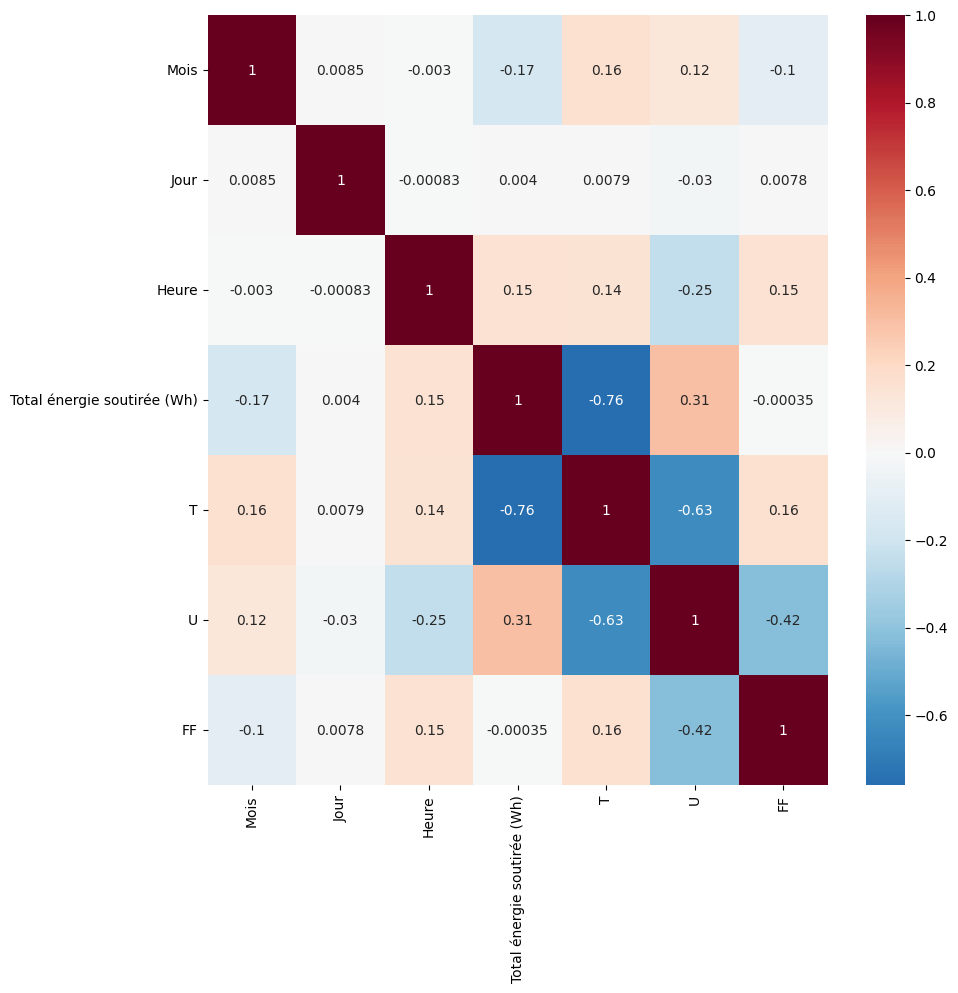

In [49]:
plt.figure(figsize=(10,10));
sns.heatmap(df_corr.corr(), center=0, annot=True, cmap='RdBu_r');

In [50]:
df_conso_elec_meteo_grouped_mois = df_conso_elec_meteo_focus[['Total énergie soutirée (Wh)', 'T', 'U', 'FF', 'Mois']].groupby('Mois').mean()

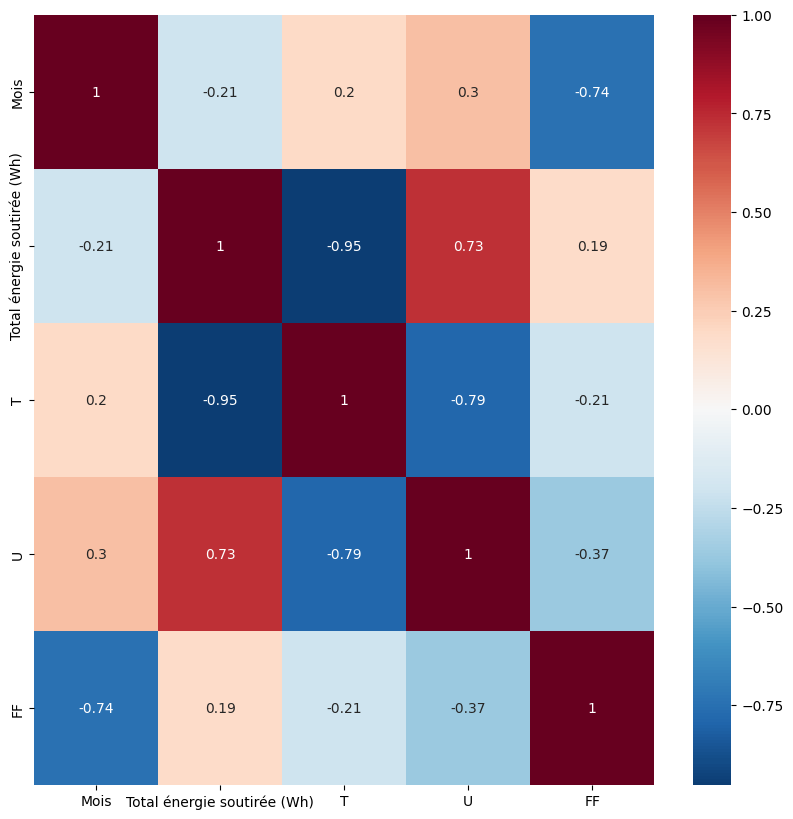

In [51]:
df_conso_elec_meteo_grouped_mois = df_conso_elec_meteo_grouped_mois.reset_index()
plt.figure(figsize=(10,10));
sns.heatmap(df_conso_elec_meteo_grouped_mois.corr(), center=0, annot=True, cmap='RdBu_r');

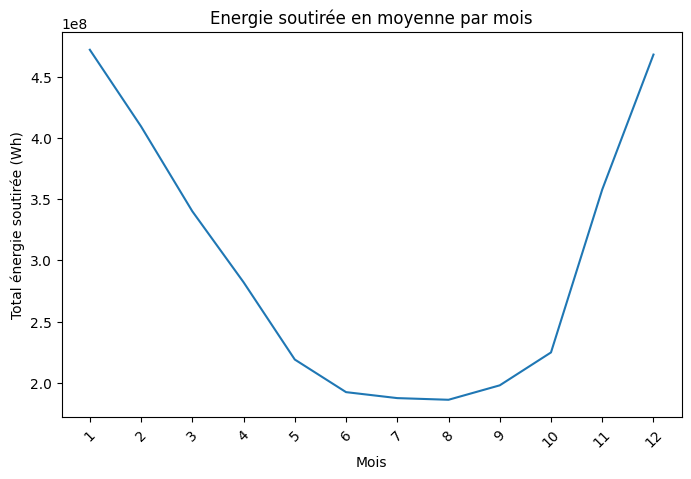

In [52]:
plt.figure(figsize=(8,5));
sns.lineplot(data=df_conso_elec_meteo_grouped_mois, x='Mois', y='Total énergie soutirée (Wh)');
plt.title("Energie soutirée en moyenne par mois");
plt.xticks([i for i in range(1,13)], rotation=45);

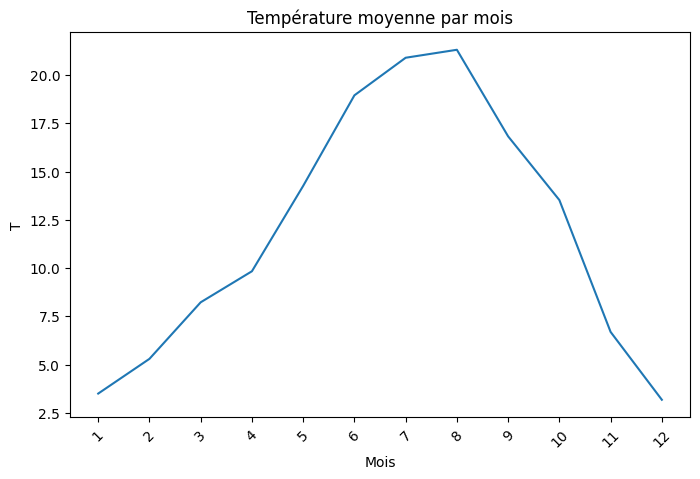

In [53]:
plt.figure(figsize=(8,5));
sns.lineplot(data=df_conso_elec_meteo_grouped_mois, x='Mois', y='T');
plt.title("Température moyenne par mois");
plt.xticks([i for i in range(1,13)], rotation=45);

In [54]:
df_conso_elec_meteo_grouped_heure = df_conso_elec_meteo_focus[['Total énergie soutirée (Wh)', 'T', 'U', 'FF', 'Heure']].groupby('Heure').mean()

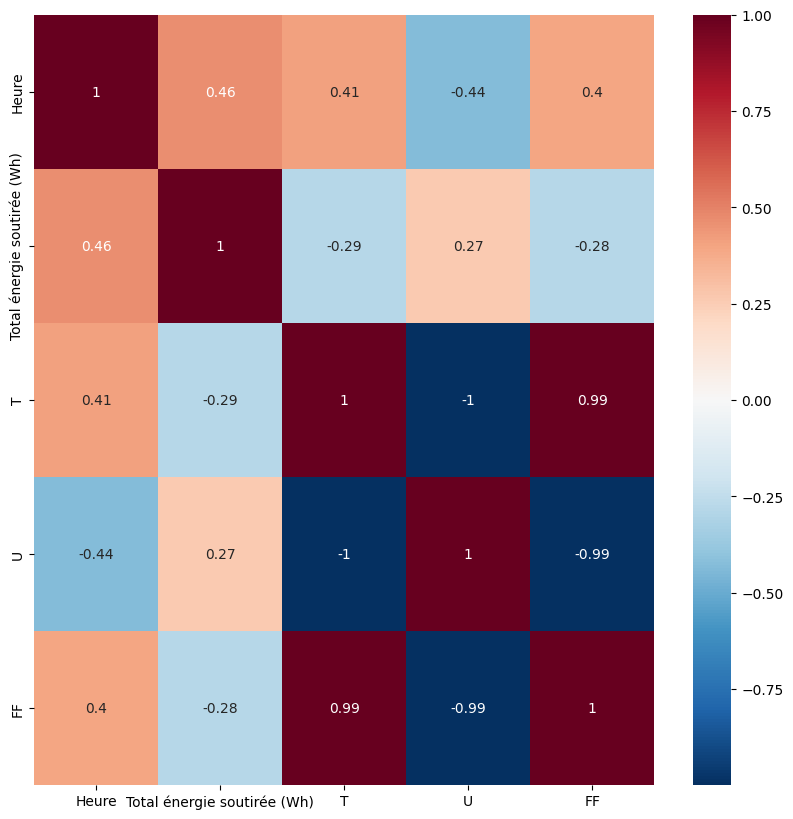

In [55]:
df_conso_elec_meteo_grouped_heure = df_conso_elec_meteo_grouped_heure.reset_index()
plt.figure(figsize=(10,10));
sns.heatmap(df_conso_elec_meteo_grouped_heure.corr(), center=0, annot=True, cmap='RdBu_r');

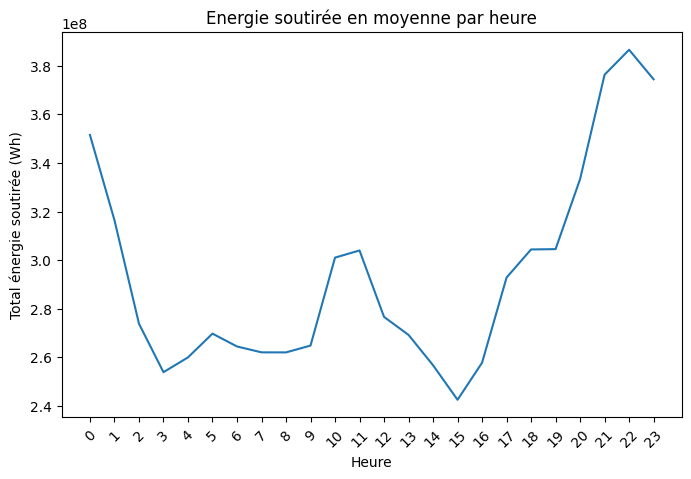

In [56]:
plt.figure(figsize=(8,5));
sns.lineplot(data=df_conso_elec_meteo_grouped_heure, x='Heure', y='Total énergie soutirée (Wh)');
plt.title("Energie soutirée en moyenne par heure");
plt.xticks([i for i in range(0,24)], rotation=45);

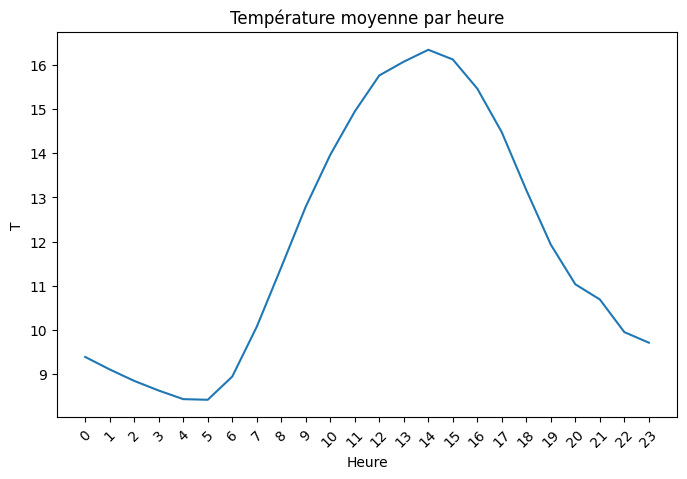

In [57]:
plt.figure(figsize=(8,5));
sns.lineplot(data=df_conso_elec_meteo_grouped_heure, x='Heure', y='T');
plt.title("Température moyenne par heure");
plt.xticks([i for i in range(0,24)], rotation=45);